In [1]:
import dlc_bci as bci

import os

import torch
import numpy as np
from matplotlib.pylab import plt

from models import *
from callbacks import keep_best_model, store_best_model

from types import SimpleNamespace 

import torch 
from torch import optim
from torch import nn

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# grid_search_on=[
#         ("nb_layers", list(range(1, 7))),
#         ("nb_hidden", [np.asscalar(n) for n in np.arange(40, 201, 40)]),
#         ("activation", [nn.ReLU, nn.Tanh, nn.ELU]),
#         ("weight_decay", [0] + [np.asscalar(wd) for wd in np.logspace(-6, -2, 5, base=np.e)]),
#         ("dropout", [np.asscalar(d) for d in np.linspace(0, 0.30, 4)]),
#         ("optimizer", [optim.Adam, optim.Adadelta, optim.Adamax]),
#         ("nb_layers", list(range(1, 7)))
#     ]

### Functions used

In [30]:
def plot_train_test(history):
    epochs = list(range(len(history.test_losses)))
    plt.figure(figsize=(7, 5))
    plt.plot(epochs, history.test_losses, label='Validation loss')
    plt.plot(epochs, history.train_losses, label='Train loss')
    plt.grid()
    plt.xlabel("epochs", fontsize=16)
    plt.ylabel("loss", fontsize=16)
    plt.legend(fontsize=13)
    
def load_best_params_and_scores(model):
    model_path =  model().dir_path
    
    # load best params
    params = torch.load(model_path + "/cross_validation" + "/best_params_")

    # load cross validation scores
    scores = torch.load(model_path + "/cross_validation/scores/nb_layers")
    crossval_scores = scores["va_scores"][params["nb_layers"]-1]

    return params, crossval_scores

def update_scores_map(scores, model_name, model, crossval_scores):
    scores[model_name] = {}
    scores[model_name]["crossval_scores"] = crossval_scores
    scores[model_name]["test_scores"] = []
    
def draw_boxplot(names, values, ylabel="Validation Accuracy"):
    plt.figure(figsize=(7, 5))
    plt.grid()

    plt.boxplot(values, patch_artist=True)
    plt.ylabel(ylabel, fontsize=16)
    plt.xlabel("Model", fontsize=16)
    locs, _ = plt.xticks()
    plt.xticks(locs, names, rotation=45,fontsize=13, ha="right")
    plt.ylim(0.6, 1)

def test_model(model_class, model_name, scores):
    # load the cross validation scores
    params, crossval_scores = load_best_params_and_scores(model_class)
    update_scores_map(scores, model_name, model_class, crossval_scores)

    # reshape the dataset
    X_tr, y_tr = model_class.prepare_data(train)
    X_tr, y_tr = X_tr.to(device), y_tr.to(device)

    X_te, y_te = model_class.prepare_data(test)
    X_te, y_te = X_te.to(device), y_te.to(device)
    
    # choose number of epochs (train on splitted train set and analyse the loss function)
    model = model_class(**params)
    model.to(device)

    n_train = int(X_tr.shape[0]*0.5)
    model.fit(X_tr[:n_train], y_tr[:n_train], X_tr[n_train:], y_tr[n_train:], epochs=100, verbose=False)
    plot_train_test(model.history)
    plt.savefig("img/" + model_name + "_epochs")
    plt.show()
    epochs = int(input("Insert the desired number of epochs:"))
    
    # compute the test scores (with the chosen number of epochs)
    scores[model_name]["test_scores"] = []
    for _ in range(n_scores):
        model = model_class(**params)
        model.to(device)

        model.fit(X_tr, y_tr, X_te, y_te, epochs=epochs, callbacks=[keep_best_model], verbose=False)
        scores[model_name]["test_scores"].append(model.score(X_te, y_te))
        print("Test score:", scores[model_name]["test_scores"][-1])

### Load data

In [5]:
one_khz=False

train = SimpleNamespace()
train.X, train.y = bci.load(root='./data_bci', one_khz=one_khz)
print(str(type(train.X)), train.X.size())
print(str(type(train.y)), train.y.size())

test = SimpleNamespace()
test.X, test.y = bci.load(root='./data_bci', train=False, one_khz=one_khz)
print(str(type(test.X)), test.X.size())
print(str(type(test.y)), test.y.size())

<class 'torch.Tensor'> torch.Size([316, 28, 50])
<class 'torch.Tensor'> torch.Size([316])
<class 'torch.Tensor'> torch.Size([100, 28, 50])
<class 'torch.Tensor'> torch.Size([100])


### Train the model on the best parameters and compute the test accuracy

In [6]:
# here we collect both the test scores and the previously compute cross validation scores for each model
n_scores = 5 # train each model 5 times to obtain an estimate of the test score
scores = {}

- `CNN2D_MaxPool`

/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:129: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()


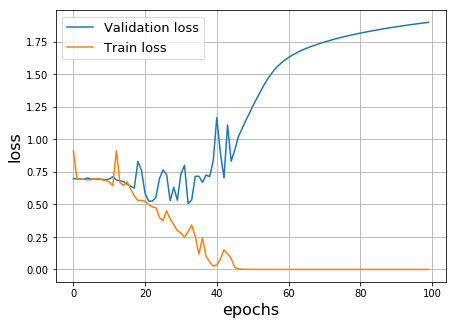

Insert the desired number of epochs:30
Test score: 0.76
Test score: 0.66
Test score: 0.71
Test score: 0.75
Test score: 0.7


In [22]:
model_name = "2D CNN"
model_class = CNN2D_MaxPool

test_model(model_class, model_name, scores)

- `CNN_1D_MaxPool`

/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:129: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()


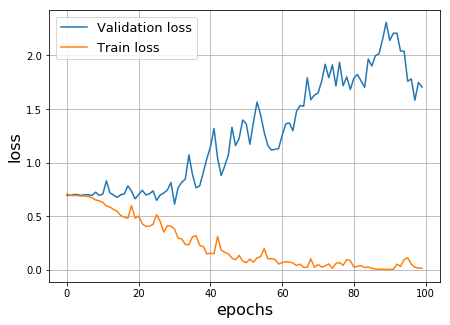

Insert the desired number of epochs:30
Test score: 0.75
Test score: 0.74
Test score: 0.76
Test score: 0.73
Test score: 0.76


In [26]:
# load the cross validation scores
model_name = "1D CNN"
model_class = CNN_1D_MaxPool

test_model(model_class, model_name, scores)

- `CNN_1D_BatchNorm`

/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:129: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()


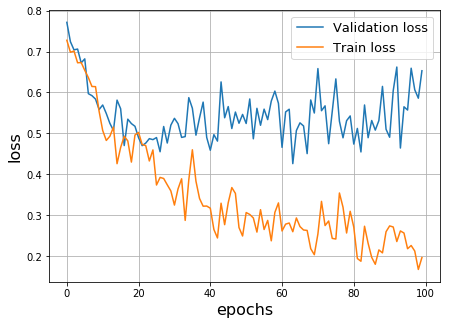

Insert the desired number of epochs:40
Test score: 0.78
Test score: 0.75
Test score: 0.76
Test score: 0.78
Test score: 0.78


In [28]:
# load the cross validation scores
model_name = "1D CNN + Batch norm"
model_class = CNN_1D_BatchNorm

test_model(model_class, model_name, scores)

- `CNN_1D_BatchNorm_Dial`

/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:129: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()


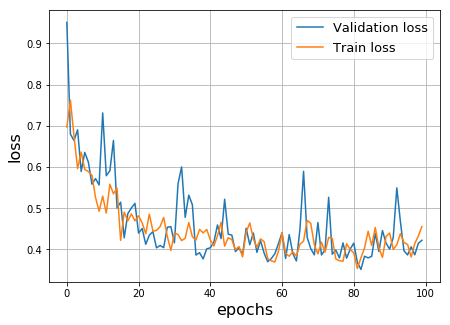

Insert the desired number of epochs:50
Test score: 0.77
Test score: 0.79
Test score: 0.73
Test score: 0.8
Test score: 0.75


In [45]:
# load the cross validation scores
model_name = "1D CNN dialated + Batch norm"
model_class = CNN_1D_BatchNorm_Dial

test_model(model_class, model_name, scores)

- `CNN_1D_Residual`

/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:129: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()


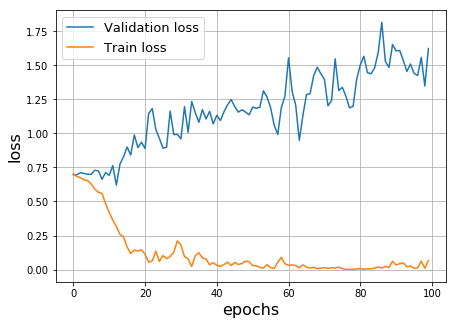

Insert the desired number of epochs:20
Test score: 0.66
Test score: 0.79
Test score: 0.71
Test score: 0.7
Test score: 0.73


In [32]:
# load the cross validation scores
model_name = "1D CNN residual"
model_class = CNN_1D_Residual

test_model(model_class, model_name, scores)

- **obtained scores**:

In [46]:
scores

{'1D CNN': {'crossval_scores': [0.71875,
   0.7619047619047619,
   0.7777777777777778,
   0.8095238095238095,
   0.873015873015873],
  'test_scores': [0.75, 0.74, 0.76, 0.73, 0.76]},
 '1D CNN + Batch norm': {'crossval_scores': [0.734375,
   0.7936507936507936,
   0.8571428571428571,
   0.7777777777777778,
   0.8253968253968254],
  'test_scores': [0.78, 0.75, 0.76, 0.78, 0.78]},
 '1D CNN dialated + Batch norm': {'crossval_scores': [0.671875,
   0.746031746031746,
   0.873015873015873,
   0.8095238095238095,
   0.7619047619047619],
  'test_scores': [0.77, 0.79, 0.73, 0.8, 0.75]},
 '1D CNN residual': {'crossval_scores': [0.8125,
   0.6984126984126984,
   0.7777777777777778,
   0.7936507936507936,
   0.6349206349206349],
  'test_scores': [0.66, 0.79, 0.71, 0.7, 0.73]},
 '2D CNN': {'crossval_scores': [0.703125,
   0.7619047619047619,
   0.8253968253968254,
   0.7936507936507936,
   0.7142857142857143],
  'test_scores': [0.76, 0.66, 0.71, 0.75, 0.7]}}

### Compare test and cross validation scores

In [47]:
print("-Test scores:")
for model_name in scores:
    sc = scores[model_name]['test_scores']
    print(model_name + ". Test Accuracy:", np.mean(sc), 
          "+-",  np.std(sc))
    
print("\n-Cross validation:")
for model_name in scores:
    sc = scores[model_name]['crossval_scores']
    print(model_name + ". Validation accuracy:", np.mean(sc), "+-",  np.std(sc))

-Test scores:
2D CNN. Test Accuracy: 0.716 +- 0.0361109401705
1D CNN. Test Accuracy: 0.748 +- 0.0116619037897
1D CNN + Batch norm. Test Accuracy: 0.77 +- 0.0126491106407
1D CNN dialated + Batch norm. Test Accuracy: 0.768 +- 0.0256124969497
1D CNN residual. Test Accuracy: 0.718 +- 0.0426145515053

-Cross validation:
2D CNN. Validation accuracy: 0.759672619048 +- 0.0463395607557
1D CNN. Validation accuracy: 0.788194444444 +- 0.0515204848119
1D CNN + Batch norm. Validation accuracy: 0.797668650794 +- 0.0417705856407
1D CNN dialated + Batch norm. Validation accuracy: 0.772470238095 +- 0.0669513508966
1D CNN residual. Validation accuracy: 0.743452380952 +- 0.0667433893367


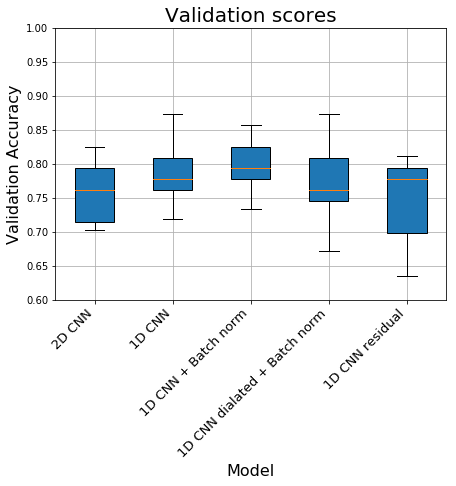

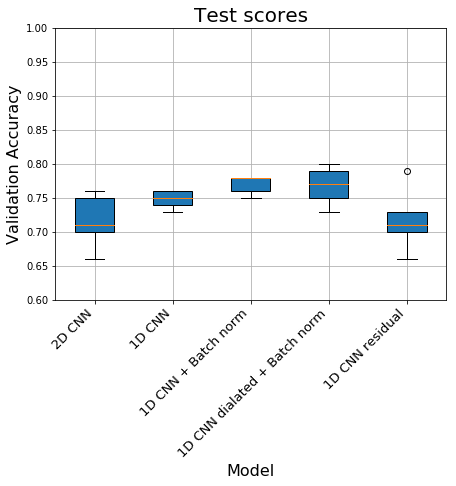

In [49]:
model_names = []
model_scores = []
for model_name in scores:
    model_names.append(model_name)
    model_scores.append(scores[model_name]['crossval_scores'])

draw_boxplot(model_names, model_scores)
plt.title("Validation scores", fontsize=20)
plt.savefig("img/cross_val_scores_boxplot")

plt.show()

model_names = []
model_scores = []
for model_name in scores:
    model_names.append(model_name)
    model_scores.append(scores[model_name]['test_scores'])
    
draw_boxplot(model_names, model_scores)
plt.title("Test scores", fontsize=20)
plt.savefig("img/test_scores_boxplot")

### Show train loss with different optimizers on `CNN_1D_BatchNorm`

In [50]:
params, crossval_scores = load_best_params_and_scores(CNN_1D_BatchNorm)

X_tr, y_tr = CNN_1D_BatchNorm.prepare_data(train)
X_tr, y_tr = X_tr.to(device), y_tr.to(device)

X_te, y_te = CNN_1D_BatchNorm.prepare_data(test)
X_te, y_te = X_te.to(device), y_te.to(device)

# remove regularitations (we are only interested in seeing how well the train loss is optimized)
params['weight_decay'] = 0
params['dropout'] = 0
params

{'activation': torch.nn.modules.activation.ELU,
 'dropout': 0,
 'nb_hidden': 160,
 'nb_layers': 5,
 'optimizer': torch.optim.adamax.Adamax,
 'weight_decay': 0}

In [51]:
# choose optimizer, train the network, save the train losses. Repeat for every optimizer
train_losses = {}

print("Training with Adam...")
params['optimizer'] = optim.Adam
model = CNN_1D_BatchNorm(**params)
model.to(device)
model.fit(X_tr, y_tr, epochs=100, verbose=False)
train_losses["Adam"] = model.history.train_losses

print("Training with Adadelta...")
params['optimizer'] = optim.Adadelta
model = CNN_1D_BatchNorm(**params)
model.to(device)
model.fit(X_tr, y_tr, epochs=100, verbose=False)
train_losses["Adadelta"] = model.history.train_losses

print("Training with Adamax...")
params['optimizer'] = optim.Adamax
model = CNN_1D_BatchNorm(**params)
model.to(device)
model.fit(X_tr, y_tr, epochs=100, verbose=False)
train_losses["Adamax"] = model.history.train_losses

Training with Adam...


/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:129: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()


Training with Adadelta...
Training with Adamax...


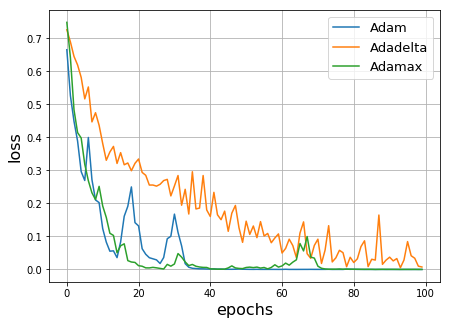

In [54]:
# plot the losses
epochs = list(range(len(train_losses["Adam"])))
plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses["Adam"], label='Adam')
plt.plot(epochs, train_losses["Adadelta"], label='Adadelta')
plt.plot(epochs, train_losses["Adamax"], label='Adamax')
plt.grid()
plt.xlabel("epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.legend(fontsize=13)

plt.savefig("img/optimizers")